# LLM Pipeline: Sentiment Analysis & Named Entity Recognition

This notebook demonstrates the complete cycle of working with data for LLM:
- Preprocessing "dirty" texts
- Creating datasets for fine-tuning
- Comparing results with classical approaches (HuggingFace models vs Local Ollama LLM)

## 1. Setup and Imports

In [ ]:
# Install required packages
!pip install pandas numpy transformers torch ollama emoji matplotlib seaborn tqdm

In [23]:
import pandas as pd
import numpy as np
import re
import json
import time
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# HuggingFace
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification

# Ollama (local LLM)
import ollama

# Emoji handling
import emoji

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. "Dirty" Dataset Analysis

### 2.1 Create DataFrame from Russian reviews with various data quality issues

In [24]:
# Sample "dirty" Russian reviews with various data quality issues
# These reviews intentionally contain: emojis, extra spaces, mixed case, typos, special characters

dirty_reviews = [
    # Positive reviews with issues
    "Отличный   товар!!!   Заказывала в  Москве,  доставили быстро 😍😍😍 Рекомендую всем!!!",
    "ОЧЕНЬ ХОРОШИЙ МАГАЗИН!!!   буду заказывать ещё  🎉🎉",
    "Качество   супер👍👍👍 Иван Петров из СПб очень доволен покупкой",
    "мне   оооочень понравилось!!!  😊😊 спасибо магазину ОЗОН за быструю доставку",
    "Превосходно!!! Анна Сидорова рекомендует   этот   товар   всем ❤️❤️❤️",
    "Товар пришёл в Санкт-Петербург    за 2 дня!!! Супер быстро 🚀🚀",
    "ВЕЛИКОЛЕПНО!!!!   Мария Иванова   из Казани в восторге  😃",
    
    # Negative reviews with issues
    "ужасный   товар...   НЕ ПОКУПАЙТЕ!!!   😡😡😡 полный брак",
    "Очень   плохое качество((( 😭😭 Деньги на ветер... Компания АлиЭкспресс - отстой",
    "КОШМАР!!!   вернул   товар   обратно в   Wildberries  😤😤",
    "не советую   никому...   Дмитрий Козлов из   Новосибирска   разочарован 👎👎",
    "Полный   ОТСТОЙ!!! Елена Волкова   НЕ рекомендует  😞😞😞",
    "товар   сломался через   день...   ужас какой-то   😢",
    "ВЕРНИТЕ ДЕНЬГИ!!!   Сергей Смирнов из   Екатеринбурга очень недоволен  🤬",
    
    # Neutral reviews with issues
    "ну   такое...   средненько   🤷‍♂️   ничего особенного",
    "Нормально,   ожидал   большего от   Яндекс Маркета   🙂",
    "Пойдёт...   за   такую   цену   сойдёт   😐",
    "Ольга Новикова   из   Нижнего Новгорода   не   определилась с оценкой  🤔",
    "Обычный   товар,   ничего   сверхъестественного...   📦",
]

# Ground truth sentiment labels
# positive = 1, negative = 0, neutral = 2
true_labels = [1, 1, 1, 1, 1, 1, 1,  # positive
               0, 0, 0, 0, 0, 0, 0,  # negative  
               2, 2, 2, 2, 2]        # neutral

label_names = {0: 'negative', 1: 'positive', 2: 'neutral'}

# Create DataFrame
df = pd.DataFrame({
    'review': dirty_reviews,
    'true_sentiment': true_labels,
    'sentiment_label': [label_names[l] for l in true_labels]
})

print(f"Dataset size: {len(df)} reviews")
print(f"\nSentiment distribution:")
print(df['sentiment_label'].value_counts())
df.head(10)

Dataset size: 19 reviews

Sentiment distribution:
sentiment_label
positive    7
negative    7
neutral     5
Name: count, dtype: int64


,review,true_sentiment,sentiment_label
0,"Отличный товар!!! Заказывала в Москве, д...",1,positive
1,ОЧЕНЬ ХОРОШИЙ МАГАЗИН!!! буду заказывать ещё...,1,positive
2,Качество супер👍👍👍 Иван Петров из СПб очень д...,1,positive
3,мне оооочень понравилось!!! 😊😊 спасибо мага...,1,positive
4,Превосходно!!! Анна Сидорова рекомендует это...,1,positive
5,Товар пришёл в Санкт-Петербург за 2 дня!!! ...,1,positive
6,ВЕЛИКОЛЕПНО!!!! Мария Иванова из Казани в ...,1,positive
7,ужасный товар... НЕ ПОКУПАЙТЕ!!! 😡😡😡 пол...,0,negative
8,Очень плохое качество((( 😭😭 Деньги на ветер....,0,negative
9,КОШМАР!!! вернул товар обратно в Wildb...,0,negative


### 2.2 Identify and Describe Data Quality Issues

In [25]:
def analyze_data_quality(texts: List[str]) -> Dict:
    """
    Analyze data quality issues in the given texts.
    
    Returns a dictionary with counts of various issues:
    - Multiple spaces
    - Emojis
    - ALL CAPS words
    - Excessive punctuation
    - Mixed case issues
    """
    issues = {
        'multiple_spaces': 0,
        'emojis': 0,
        'all_caps_words': 0,
        'excessive_punctuation': 0,
        'texts_with_issues': 0
    }
    
    detailed_issues = []
    
    for i, text in enumerate(texts):
        text_issues = []
        
        # Check for multiple consecutive spaces
        if re.search(r'\s{2,}', text):
            issues['multiple_spaces'] += 1
            text_issues.append('multiple_spaces')
        
        # Check for emojis
        emoji_count = len([c for c in text if c in emoji.EMOJI_DATA])
        if emoji_count > 0:
            issues['emojis'] += 1
            text_issues.append(f'emojis ({emoji_count})')
        
        # Check for ALL CAPS words (at least 3 characters)
        caps_words = re.findall(r'\b[А-ЯA-Z]{3,}\b', text)
        if caps_words:
            issues['all_caps_words'] += 1
            text_issues.append(f'all_caps ({len(caps_words)} words)')
        
        # Check for excessive punctuation (3+ consecutive)
        if re.search(r'[!?.,]{3,}', text):
            issues['excessive_punctuation'] += 1
            text_issues.append('excessive_punctuation')
        
        if text_issues:
            issues['texts_with_issues'] += 1
            detailed_issues.append({'index': i, 'text': text[:50] + '...', 'issues': text_issues})
    
    return issues, detailed_issues


# Analyze the dataset
issues_summary, detailed = analyze_data_quality(df['review'].tolist())

print("=" * 60)
print("DATA QUALITY ANALYSIS REPORT")
print("=" * 60)
print(f"\nTotal texts analyzed: {len(df)}")
print(f"Texts with issues: {issues_summary['texts_with_issues']} ({issues_summary['texts_with_issues']/len(df)*100:.1f}%)")
print(f"\nIssue breakdown:")
print(f"  - Multiple spaces: {issues_summary['multiple_spaces']} texts")
print(f"  - Contains emojis: {issues_summary['emojis']} texts")
print(f"  - ALL CAPS words: {issues_summary['all_caps_words']} texts")
print(f"  - Excessive punctuation: {issues_summary['excessive_punctuation']} texts")

print(f"\n\nDetailed issues (first 5):")
print("-" * 60)
for item in detailed[:5]:
    print(f"Index {item['index']}: {item['text']}")
    print(f"  Issues: {', '.join(item['issues'])}")
    print()

DATA QUALITY ANALYSIS REPORT

Total texts analyzed: 19
Texts with issues: 19 (100.0%)

Issue breakdown:
  - Multiple spaces: 19 texts
  - Contains emojis: 19 texts
  - ALL CAPS words: 7 texts
  - Excessive punctuation: 16 texts


Detailed issues (first 5):
------------------------------------------------------------
Index 0: Отличный   товар!!!   Заказывала в  Москве,  доста...
  Issues: multiple_spaces, emojis (3), excessive_punctuation

Index 1: ОЧЕНЬ ХОРОШИЙ МАГАЗИН!!!   буду заказывать ещё  🎉🎉...
  Issues: multiple_spaces, emojis (2), all_caps (3 words), excessive_punctuation

Index 2: Качество   супер👍👍👍 Иван Петров из СПб очень довол...
  Issues: multiple_spaces, emojis (3)

Index 3: мне   оооочень понравилось!!!  😊😊 спасибо магазину...
  Issues: multiple_spaces, emojis (2), all_caps (1 words), excessive_punctuation

Index 4: Превосходно!!! Анна Сидорова рекомендует   этот   ...
  Issues: multiple_spaces, emojis (3), excessive_punctuation



## 3. Data Cleaning and Normalization

### 3.1 Implement clean_text() function for Russian texts

In [26]:
def clean_text(text: str, 
               remove_emojis: bool = True,
               normalize_spaces: bool = True,
               fix_case: bool = True,
               normalize_punctuation: bool = True,
               preserve_names: bool = True) -> str:
    """
    Clean and normalize Russian text.
    
    Parameters:
    -----------
    text : str
        Input text to clean
    remove_emojis : bool
        Remove all emoji characters
    normalize_spaces : bool
        Replace multiple spaces with single space
    fix_case : bool
        Normalize text case (first letter uppercase, rest lowercase for sentences)
    normalize_punctuation : bool
        Reduce excessive punctuation (e.g., !!! -> !)
    preserve_names : bool
        Try to preserve capitalization of proper names (cities, people)
    
    Returns:
    --------
    str : Cleaned text
    """
    if not text or not isinstance(text, str):
        return ""
    
    cleaned = text
    
    # Step 1: Remove emojis
    if remove_emojis:
        # Remove emoji characters using regex pattern for emoji ranges
        cleaned = emoji.replace_emoji(cleaned, replace='')
    
    # Step 2: Normalize punctuation (reduce !!! to !, ??? to ?, etc.)
    if normalize_punctuation:
        cleaned = re.sub(r'([!?.]){2,}', r'\1', cleaned)
        cleaned = re.sub(r'\(+', '(', cleaned)
        cleaned = re.sub(r'\)+', ')', cleaned)
    
    # Step 3: Normalize spaces (multiple spaces to single)
    if normalize_spaces:
        cleaned = re.sub(r'\s+', ' ', cleaned)
        cleaned = cleaned.strip()
    
    # Step 4: Fix case
    if fix_case:
        # List of common Russian proper names and cities to preserve
        proper_names = [
            'Москва', 'Санкт-Петербург', 'СПб', 'Казань', 'Новосибирск', 
            'Екатеринбург', 'Нижний Новгород', 'Россия',
            'Иван', 'Петр', 'Анна', 'Мария', 'Елена', 'Ольга', 'Дмитрий',
            'Сергей', 'Александр', 'Петров', 'Иванова', 'Сидорова', 'Козлов',
            'Волкова', 'Смирнов', 'Новикова',
            'ОЗОН', 'Озон', 'Wildberries', 'АлиЭкспресс', 'Яндекс'
        ]
        
        # Store positions of proper names to restore later
        name_positions = []
        if preserve_names:
            for name in proper_names:
                for match in re.finditer(re.escape(name), cleaned, re.IGNORECASE):
                    name_positions.append((match.start(), match.end(), name))
        
        # Convert to lowercase first
        cleaned = cleaned.lower()
        
        # Capitalize first letter of sentences
        sentences = re.split(r'([.!?]\s*)', cleaned)
        result = []
        for i, part in enumerate(sentences):
            if part and i % 2 == 0:  # This is a sentence, not punctuation
                part = part[0].upper() + part[1:] if len(part) > 0 else part
            result.append(part)
        cleaned = ''.join(result)
        
        # Restore proper names
        if preserve_names:
            for name in proper_names:
                # Case-insensitive replacement
                cleaned = re.sub(re.escape(name.lower()), name, cleaned, flags=re.IGNORECASE)
    
    return cleaned


# Test the cleaning function
print("Testing clean_text() function:")
print("=" * 60)

test_texts = [
    "Отличный   товар!!!   Заказывала в  Москве,  доставили быстро 😍😍😍",
    "ОЧЕНЬ ХОРОШИЙ МАГАЗИН!!!   буду заказывать ещё  🎉🎉",
    "ужасный   товар...   НЕ ПОКУПАЙТЕ!!!   😡😡😡"
]

for text in test_texts:
    cleaned = clean_text(text)
    print(f"Original: {text}")
    print(f"Cleaned:  {cleaned}")
    print("-" * 60)

Testing clean_text() function:
Original: Отличный   товар!!!   Заказывала в  Москве,  доставили быстро 😍😍😍
Cleaned:  Отличный товар! Заказывала в москве, доставили быстро
------------------------------------------------------------
Original: ОЧЕНЬ ХОРОШИЙ МАГАЗИН!!!   буду заказывать ещё  🎉🎉
Cleaned:  Очень хороший магазин! Буду заказывать ещё
------------------------------------------------------------
Original: ужасный   товар...   НЕ ПОКУПАЙТЕ!!!   😡😡😡
Cleaned:  Ужасный товар. Не покупайте!
------------------------------------------------------------


### 3.2 Apply cleaning to the dataset

In [27]:
# Apply cleaning to all reviews
df['cleaned_review'] = df['review'].apply(clean_text)

# Display before and after comparison
print("Before and After Cleaning:")
print("=" * 80)
for idx, row in df.head(6).iterrows():
    print(f"\n[{row['sentiment_label'].upper()}]")
    print(f"Original: {row['review'][:80]}...")
    print(f"Cleaned:  {row['cleaned_review'][:80]}...")

# Verify data quality after cleaning
issues_after, _ = analyze_data_quality(df['cleaned_review'].tolist())
print("\n" + "=" * 80)
print("Data quality after cleaning:")
print(f"  - Multiple spaces: {issues_after['multiple_spaces']} texts")
print(f"  - Contains emojis: {issues_after['emojis']} texts")
print(f"  - ALL CAPS words: {issues_after['all_caps_words']} texts")
print(f"  - Excessive punctuation: {issues_after['excessive_punctuation']} texts")

Before and After Cleaning:

[POSITIVE]
Original: Отличный   товар!!!   Заказывала в  Москве,  доставили быстро 😍😍😍 Рекомендую все...
Cleaned:  Отличный товар! Заказывала в москве, доставили быстро рекомендую всем!...

[POSITIVE]
Original: ОЧЕНЬ ХОРОШИЙ МАГАЗИН!!!   буду заказывать ещё  🎉🎉...
Cleaned:  Очень хороший магазин! Буду заказывать ещё...

[POSITIVE]
Original: Качество   супер👍👍👍 Иван Петров из СПб очень доволен покупкой...
Cleaned:  Качество супер Иван Петров из СПб очень доволен покупкой...

[POSITIVE]
Original: мне   оооочень понравилось!!!  😊😊 спасибо магазину ОЗОН за быструю доставку...
Cleaned:  Мне оооочень понравилось! Спасибо магазину Озон за быструю доставку...

[POSITIVE]
Original: Превосходно!!! Анна Сидорова рекомендует   этот   товар   всем ❤️❤️❤️...
Cleaned:  Превосходно! Анна Сидорова рекомендует этот товар всем...

[POSITIVE]
Original: Товар пришёл в Санкт-Петербург    за 2 дня!!! Супер быстро 🚀🚀...
Cleaned:  Товар пришёл в Санкт-Петербург за 2 дня! Супер быстр

## 4. Using HuggingFace Models

### 4.1 Load Russian Sentiment Analysis Model

In [28]:
# Load Russian sentiment analysis model from HuggingFace
# Using a multilingual model that works well with Russian

print("Loading sentiment analysis model...")
sentiment_model_name = "blanchefort/rubert-base-cased-sentiment"

try:
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model=sentiment_model_name,
        tokenizer=sentiment_model_name
    )
    print(f"Successfully loaded: {sentiment_model_name}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Trying alternative model...")
    # Fallback to multilingual model
    sentiment_model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model=sentiment_model_name,
        tokenizer=sentiment_model_name
    )
    print(f"Successfully loaded fallback: {sentiment_model_name}")

Loading sentiment analysis model...


Device set to use cuda:0


Successfully loaded: blanchefort/rubert-base-cased-sentiment


### 4.2 Load Russian NER Model

In [29]:
# Load Russian/Multilingual NER model
print("Loading NER model...")

# List of NER models to try (in order of preference for Russian)
ner_models_to_try = [
    "Babelscape/wikineural-multilingual-ner",  # Good multilingual NER including Russian
    "Davlan/xlm-roberta-base-ner-hrl",         # Multilingual NER (high-resource languages)
    "dslim/bert-base-NER",                      # Fallback English NER
]

ner_pipeline = None
ner_model_name = None

for model_name in ner_models_to_try:
    try:
        print(f"Trying: {model_name}...")
        ner_pipeline = pipeline(
            "ner",
            model=model_name,
            tokenizer=model_name,
            aggregation_strategy="simple"  # Group tokens into entities
        )
        ner_model_name = model_name
        print(f"Successfully loaded: {model_name}")
        break
    except Exception as e:
        print(f"  Failed: {e}")
        continue

if ner_pipeline is None:
    print("WARNING: Could not load any NER model. NER functionality will be limited.")
    ner_model_name = "None"

Loading NER model...
Trying: Babelscape/wikineural-multilingual-ner...


Device set to use cuda:0


Successfully loaded: Babelscape/wikineural-multilingual-ner


### 4.3 Implement Analysis Functions

In [30]:
def analyze_sentiment_hf(text: str, analyzer) -> Dict:
    """
    Analyze sentiment using HuggingFace model.
    
    Returns dict with label and confidence score.
    """
    try:
        result = analyzer(text, truncation=True, max_length=512)[0]
        return {
            'label': result['label'].lower(),
            'score': round(result['score'], 4)
        }
    except Exception as e:
        return {'label': 'error', 'score': 0.0, 'error': str(e)}


def analyze_ner_hf(text: str, ner_model) -> List[Dict]:
    """
    Extract named entities using HuggingFace NER model.
    
    Returns list of entities with their types and positions.
    """
    if ner_model is None:
        return [{'note': 'NER model not available'}]
    
    try:
        entities = ner_model(text)
        # Format results
        formatted = []
        for ent in entities:
            formatted.append({
                'entity': ent.get('word', ent.get('entity_group', '')),
                'type': ent.get('entity_group', ent.get('entity', '')),
                'score': round(ent.get('score', 0), 4)
            })
        return formatted
    except Exception as e:
        return [{'error': str(e)}]


def analyze_text_full_hf(text: str, sentiment_model, ner_model) -> Dict:
    """
    Perform full analysis: sentiment + NER using HuggingFace models.
    """
    start_time = time.time()
    
    sentiment = analyze_sentiment_hf(text, sentiment_model)
    entities = analyze_ner_hf(text, ner_model)
    
    elapsed = time.time() - start_time
    
    return {
        'text': text,
        'sentiment': sentiment,
        'entities': entities,
        'processing_time_ms': round(elapsed * 1000, 2)
    }


# Test on sample texts
print("Testing HuggingFace models on sample texts:")
print("=" * 70)

sample_texts = df['cleaned_review'].head(5).tolist()

for text in sample_texts:
    result = analyze_text_full_hf(text, sentiment_analyzer, ner_pipeline)
    print(f"\nText: {text[:60]}...")
    print(f"Sentiment: {result['sentiment']['label']} (confidence: {result['sentiment']['score']})")
    print(f"Entities: {result['entities']}")
    print(f"Processing time: {result['processing_time_ms']} ms")

Testing HuggingFace models on sample texts:

Text: Отличный товар! Заказывала в москве, доставили быстро рекоме...
Sentiment: positive (confidence: 0.9813)
Entities: [{'entity': 'м', 'type': 'MISC', 'score': 0.9221}, {'entity': '##ос', 'type': 'MISC', 'score': 0.4781}]
Processing time: 30.51 ms

Text: Очень хороший магазин! Буду заказывать ещё...
Sentiment: positive (confidence: 0.9811)
Entities: []
Processing time: 34.0 ms

Text: Качество супер Иван Петров из СПб очень доволен покупкой...
Sentiment: positive (confidence: 0.981)
Entities: [{'entity': 'Иван Петров', 'type': 'PER', 'score': 0.9992}, {'entity': 'СПб', 'type': 'LOC', 'score': 0.9937}]
Processing time: 22.0 ms

Text: Мне оооочень понравилось! Спасибо магазину Озон за быструю д...
Sentiment: positive (confidence: 0.9804)
Entities: [{'entity': 'Озон', 'type': 'PER', 'score': 0.5526}]
Processing time: 27.52 ms

Text: Превосходно! Анна Сидорова рекомендует этот товар всем...
Sentiment: negative (confidence: 0.7511)
Entities: [{

### 4.4 Run HuggingFace Analysis on Full Dataset

In [31]:
# Analyze all texts with HuggingFace models
hf_results = []
hf_processing_times = []

print("Processing all texts with HuggingFace models...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    result = analyze_text_full_hf(
        row['cleaned_review'], 
        sentiment_analyzer, 
        ner_pipeline
    )
    hf_results.append(result)
    hf_processing_times.append(result['processing_time_ms'])

# Add results to DataFrame
df['hf_sentiment'] = [r['sentiment']['label'] for r in hf_results]
df['hf_sentiment_score'] = [r['sentiment']['score'] for r in hf_results]
df['hf_entities'] = [r['entities'] for r in hf_results]
df['hf_time_ms'] = hf_processing_times

print(f"\nTotal processing time: {sum(hf_processing_times):.2f} ms")
print(f"Average per text: {np.mean(hf_processing_times):.2f} ms")

# Display results
df[['cleaned_review', 'sentiment_label', 'hf_sentiment', 'hf_sentiment_score']].head(10)

Processing all texts with HuggingFace models...


100%|██████████| 19/19 [00:00<00:00, 38.49it/s]


Total processing time: 487.62 ms
Average per text: 25.66 ms


,cleaned_review,sentiment_label,hf_sentiment,hf_sentiment_score
0,"Отличный товар! Заказывала в москве, доставили...",positive,positive,0.9813
1,Очень хороший магазин! Буду заказывать ещё,positive,positive,0.9811
2,Качество супер Иван Петров из СПб очень доволе...,positive,positive,0.9810
3,Мне оооочень понравилось! Спасибо магазину Озо...,positive,positive,0.9804
4,Превосходно! Анна Сидорова рекомендует этот то...,positive,negative,0.7511
5,Товар пришёл в Санкт-Петербург за 2 дня! Супер...,positive,positive,0.8868
6,Великолепно! Мария Иванова из казани в восторге,positive,positive,0.9806
7,Ужасный товар. Не покупайте! Полный брак,negative,negative,0.7515
8,Очень плохое качество( деньги на ветер. Компан...,negative,negative,0.7518
9,Кошмар! Вернул товар обратно в Wildberries,negative,negative,0.7515


## 5. Creating Effective Prompts for LLM

### 5.1 Develop Prompts for Sentiment Analysis and NER

In [32]:
# Prompt templates for OpenAI API
# These prompts are designed specifically for Russian language analysis

SENTIMENT_PROMPT_TEMPLATE = """Analyze the sentiment of the following Russian text review.

Rules:
1. Classify the sentiment as exactly one of: "positive", "negative", or "neutral"
2. Consider Russian-specific expressions and slang
3. Multiple exclamation marks often indicate strong emotion
4. Words like "ужас", "кошмар", "отстой" indicate negative sentiment
5. Words like "супер", "отлично", "великолепно" indicate positive sentiment
6. Provide a confidence score from 0.0 to 1.0

Text: {text}

Respond ONLY with valid JSON in this exact format:
{{"sentiment": "<positive|negative|neutral>", "confidence": <0.0-1.0>}}"""


NER_PROMPT_TEMPLATE = """Extract named entities from the following Russian text.

Entity types to extract:
- PER (Person names): First names, last names, patronymics
- LOC (Locations): Cities, countries, regions, addresses
- ORG (Organizations): Companies, stores, brands, services

Rules:
1. Include only explicitly mentioned entities
2. Preserve original text form of the entity
3. Common Russian store names: ОЗОН, Wildberries, Яндекс Маркет, АлиЭкспресс
4. Common Russian city abbreviations: СПб = Санкт-Петербург, МСК = Москва

Text: {text}

Respond ONLY with valid JSON in this exact format:
{{"entities": [{{"text": "<entity text>", "type": "<PER|LOC|ORG>"}}]}}"""


COMBINED_PROMPT_TEMPLATE = """Analyze the following Russian review text. Perform both sentiment analysis and named entity recognition.

SENTIMENT ANALYSIS:
- Classify as: "positive", "negative", or "neutral"
- Consider Russian expressions: "ужас/кошмар/отстой" = negative, "супер/отлично" = positive
- Provide confidence score (0.0-1.0)

NAMED ENTITY RECOGNITION:
- PER: Person names (Russian names like Иван Петров)
- LOC: Locations (Москва, СПб, etc.)
- ORG: Organizations (ОЗОН, Wildberries, Яндекс Маркет)

Text: {text}

Respond ONLY with valid JSON:
{{
  "sentiment": {{"label": "<positive|negative|neutral>", "confidence": <0.0-1.0>}},
  "entities": [{{"text": "<entity>", "type": "<PER|LOC|ORG>"}}]
}}"""

print("Prompt templates created.")
print("\n" + "=" * 60)
print("Example Combined Prompt:")
print("=" * 60)
print(COMBINED_PROMPT_TEMPLATE.format(text="Отличный товар! Иван из Москвы рекомендует ОЗОН."))

Prompt templates created.

Example Combined Prompt:
Analyze the following Russian review text. Perform both sentiment analysis and named entity recognition.

SENTIMENT ANALYSIS:
- Classify as: "positive", "negative", or "neutral"
- Consider Russian expressions: "ужас/кошмар/отстой" = negative, "супер/отлично" = positive
- Provide confidence score (0.0-1.0)

NAMED ENTITY RECOGNITION:
- PER: Person names (Russian names like Иван Петров)
- LOC: Locations (Москва, СПб, etc.)
- ORG: Organizations (ОЗОН, Wildberries, Яндекс Маркет)

Text: Отличный товар! Иван из Москвы рекомендует ОЗОН.

Respond ONLY with valid JSON:
{
  "sentiment": {"label": "<positive|negative|neutral>", "confidence": <0.0-1.0>},
  "entities": [{"text": "<entity>", "type": "<PER|LOC|ORG>"}]
}


## 6. Working with Local Ollama LLM

### 6.1 Setup and Model Selection

Ollama runs LLMs locally - no API key required!
Available models that work well with Russian:
- `llama3.2` - Good general purpose, supports multiple languages
- `mistral` - Excellent for European languages including Russian
- `qwen2.5` - Strong multilingual support including Russian
- `gemma2` - Google's model with good multilingual capabilities

Make sure Ollama is running: `ollama serve`
Pull a model first: `ollama pull llama3.2`

In [33]:
# Check Ollama availability and list models
# Preferred models for Russian text analysis (in order of preference)
PREFERRED_MODELS = ['qwen2.5:latest', 'qwen2.5', 'llama3.2:latest', 'llama3.2', 'mistral:latest', 'mistral', 'gemma2:latest', 'gemma2']

USE_OLLAMA = False
OLLAMA_MODEL = None

try:
    # Check if Ollama is running and get available models
    available_models = ollama.list()
    model_names = [m['name'] for m in available_models.get('models', [])]
    
    print("Ollama is running!")
    print(f"Available models: {model_names}")
    
    # Select the best available model
    for preferred in PREFERRED_MODELS:
        for model in model_names:
            if preferred in model or model.startswith(preferred.split(':')[0]):
                OLLAMA_MODEL = model
                break
        if OLLAMA_MODEL:
            break
    
    if OLLAMA_MODEL:
        USE_OLLAMA = True
        print(f"\nSelected model: {OLLAMA_MODEL}")
    else:
        print("\nNo preferred model found. Please pull a model:")
        print("  ollama pull llama3.2")
        print("  ollama pull qwen2.5")
        print("  ollama pull mistral")
        
except Exception as e:
    print(f"Ollama not available: {e}")
    print("\nTo use Ollama:")
    print("1. Install Ollama from https://ollama.ai")
    print("2. Run 'ollama serve' in terminal")
    print("3. Pull a model: 'ollama pull llama3.2'")

Ollama not available: 'name'

To use Ollama:
1. Install Ollama from https://ollama.ai
2. Run 'ollama serve' in terminal
3. Pull a model: 'ollama pull llama3.2'


### 6.2 Implement Ollama API Functions

In [34]:
def call_ollama_api(prompt: str, 
                    model: str = None,
                    temperature: float = 0.0,
                    max_retries: int = 3) -> Dict:
    """
    Call Ollama API with error handling and retries.
    
    Parameters:
    -----------
    prompt : str
        The prompt to send to the API
    model : str
        Model to use (defaults to OLLAMA_MODEL)
    temperature : float
        Sampling temperature (0.0 for deterministic)
    max_retries : int
        Number of retry attempts on failure
    
    Returns:
    --------
    Dict with response content and metadata
    """
    if not USE_OLLAMA:
        return {
            'success': False,
            'error': 'Ollama not available',
            'content': None
        }
    
    model = model or OLLAMA_MODEL
    
    for attempt in range(max_retries):
        try:
            start_time = time.time()
            
            response = ollama.chat(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that analyzes Russian text. Always respond with valid JSON only, no additional text."},
                    {"role": "user", "content": prompt}
                ],
                options={
                    "temperature": temperature,
                    "num_predict": 500
                }
            )
            
            elapsed = time.time() - start_time
            content = response['message']['content']
            
            return {
                'success': True,
                'content': content,
                'model': model,
                'processing_time_ms': round(elapsed * 1000, 2),
                'tokens_used': response.get('eval_count', 0) + response.get('prompt_eval_count', 0)
            }
            
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Error (attempt {attempt + 1}/{max_retries}): {e}")
                time.sleep(1)
            else:
                return {
                    'success': False,
                    'error': str(e),
                    'content': None
                }
    
    return {
        'success': False,
        'error': 'Max retries exceeded',
        'content': None
    }


def parse_json_response(response_text: str) -> Dict:
    """
    Parse JSON from Ollama response, handling common issues.
    """
    if not response_text:
        return {'error': 'Empty response'}
    
    try:
        # Try to extract JSON if wrapped in markdown code blocks
        if '```json' in response_text:
            response_text = response_text.split('```json')[1].split('```')[0]
        elif '```' in response_text:
            response_text = response_text.split('```')[1].split('```')[0]
        
        # Find JSON object in response
        start_idx = response_text.find('{')
        end_idx = response_text.rfind('}') + 1
        if start_idx != -1 and end_idx > start_idx:
            response_text = response_text[start_idx:end_idx]
        
        return json.loads(response_text.strip())
    except json.JSONDecodeError as e:
        return {'error': f'JSON parse error: {e}', 'raw': response_text}


def analyze_text_ollama(text: str, prompt_template: str = COMBINED_PROMPT_TEMPLATE) -> Dict:
    """
    Analyze text using Ollama with the given prompt template.
    """
    prompt = prompt_template.format(text=text)
    
    response = call_ollama_api(prompt)
    
    if response['success']:
        parsed = parse_json_response(response['content'])
        return {
            'success': True,
            'result': parsed,
            'processing_time_ms': response['processing_time_ms'],
            'tokens_used': response['tokens_used']
        }
    else:
        return {
            'success': False,
            'error': response.get('error'),
            'result': None
        }


# Test the Ollama functions (if available)
if USE_OLLAMA:
    print(f"Testing Ollama with model: {OLLAMA_MODEL}...")
    test_text = "Отличный товар! Иван Петров из Москвы рекомендует магазин ОЗОН."
    result = analyze_text_ollama(test_text)
    
    if result['success']:
        print(f"\nTest text: {test_text}")
        print(f"Result: {json.dumps(result['result'], ensure_ascii=False, indent=2)}")
        print(f"Processing time: {result['processing_time_ms']} ms")
        print(f"Tokens used: {result['tokens_used']}")
    else:
        print(f"Error: {result.get('error')}")
else:
    print("Skipping Ollama test (Ollama not available)")

Skipping Ollama test (Ollama not available)


### 6.3 Run Ollama Analysis on Dataset

In [35]:
# Analyze all texts with Ollama
ollama_results = []
ollama_processing_times = []

if USE_OLLAMA:
    print(f"Processing all texts with Ollama ({OLLAMA_MODEL})...")
    print("(Local processing - no API rate limits!)\n")
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        result = analyze_text_ollama(row['cleaned_review'])
        ollama_results.append(result)
        
        if result['success']:
            ollama_processing_times.append(result['processing_time_ms'])
    
    # Extract results
    df['ollama_sentiment'] = [
        r.get('result', {}).get('sentiment', {}).get('label', 'unknown') 
        if r['success'] and isinstance(r.get('result', {}).get('sentiment'), dict)
        else (r.get('result', {}).get('sentiment', 'unknown') if r['success'] else 'error')
        for r in ollama_results
    ]
    df['ollama_confidence'] = [
        r.get('result', {}).get('sentiment', {}).get('confidence', 0) 
        if r['success'] and isinstance(r.get('result', {}).get('sentiment'), dict)
        else 0
        for r in ollama_results
    ]
    df['ollama_entities'] = [
        r.get('result', {}).get('entities', []) 
        if r['success'] else []
        for r in ollama_results
    ]
    df['ollama_time_ms'] = [
        r.get('processing_time_ms', 0) 
        if r['success'] else 0
        for r in ollama_results
    ]
    
    print(f"\nTotal processing time: {sum(ollama_processing_times):.2f} ms")
    print(f"Average per text: {np.mean(ollama_processing_times):.2f} ms")
else:
    print("Ollama not available. Creating placeholder columns...")
    # Create placeholder columns for comparison
    df['ollama_sentiment'] = 'N/A'
    df['ollama_confidence'] = 0
    df['ollama_entities'] = [[]]*len(df)
    df['ollama_time_ms'] = 0

# Display results
df[['cleaned_review', 'sentiment_label', 'hf_sentiment', 'ollama_sentiment']].head(10)

Ollama not available. Creating placeholder columns...


,cleaned_review,sentiment_label,hf_sentiment,ollama_sentiment
0,"Отличный товар! Заказывала в москве, доставили...",positive,positive,N/A
1,Очень хороший магазин! Буду заказывать ещё,positive,positive,N/A
2,Качество супер Иван Петров из СПб очень доволе...,positive,positive,N/A
3,Мне оооочень понравилось! Спасибо магазину Озо...,positive,positive,N/A
4,Превосходно! Анна Сидорова рекомендует этот то...,positive,negative,N/A
5,Товар пришёл в Санкт-Петербург за 2 дня! Супер...,positive,positive,N/A
6,Великолепно! Мария Иванова из казани в восторге,positive,positive,N/A
7,Ужасный товар. Не покупайте! Полный брак,negative,negative,N/A
8,Очень плохое качество( деньги на ветер. Компан...,negative,negative,N/A
9,Кошмар! Вернул товар обратно в Wildberries,negative,negative,N/A


## 7. Comparison of Results

### 7.1 Calculate Accuracy Metrics

In [36]:
def calculate_accuracy(true_labels: List[str], predicted_labels: List[str]) -> Dict:
    """
    Calculate accuracy metrics for sentiment classification.
    """
    # Normalize labels
    true_normalized = [str(l).lower() for l in true_labels]
    pred_normalized = [str(l).lower() for l in predicted_labels]
    
    # Filter out errors/N/A
    valid_pairs = [(t, p) for t, p in zip(true_normalized, pred_normalized) 
                   if p not in ['error', 'n/a', 'unknown', 'none']]
    
    if not valid_pairs:
        return {'accuracy': 0, 'total': 0, 'correct': 0}
    
    true_valid = [t for t, p in valid_pairs]
    pred_valid = [p for t, p in valid_pairs]
    
    correct = sum(1 for t, p in zip(true_valid, pred_valid) if t == p)
    total = len(valid_pairs)
    
    return {
        'accuracy': round(correct / total * 100, 2),
        'correct': correct,
        'total': total
    }


# Calculate accuracy for HuggingFace
hf_accuracy = calculate_accuracy(df['sentiment_label'].tolist(), df['hf_sentiment'].tolist())

# Calculate accuracy for Ollama
ollama_accuracy = calculate_accuracy(df['sentiment_label'].tolist(), df['ollama_sentiment'].tolist())

print("=" * 60)
print("ACCURACY COMPARISON")
print("=" * 60)
print(f"\nHuggingFace Model ({sentiment_model_name}):")
print(f"  Accuracy: {hf_accuracy['accuracy']}%")
print(f"  Correct: {hf_accuracy['correct']}/{hf_accuracy['total']}")

if USE_OLLAMA:
    print(f"\nOllama ({OLLAMA_MODEL}):")
    print(f"  Accuracy: {ollama_accuracy['accuracy']}%")
    print(f"  Correct: {ollama_accuracy['correct']}/{ollama_accuracy['total']}")
else:
    print("\nOllama: Not available")

ACCURACY COMPARISON

HuggingFace Model (blanchefort/rubert-base-cased-sentiment):
  Accuracy: 94.74%
  Correct: 18/19

Ollama: Not available


### 7.2 Compare Processing Speed

In [37]:
# Speed comparison
print("=" * 60)
print("SPEED COMPARISON")
print("=" * 60)

print(f"\nHuggingFace Model:")
print(f"  Total time: {sum(hf_processing_times):.2f} ms")
print(f"  Average per text: {np.mean(hf_processing_times):.2f} ms")
print(f"  Min: {min(hf_processing_times):.2f} ms")
print(f"  Max: {max(hf_processing_times):.2f} ms")

if USE_OLLAMA and ollama_processing_times:
    print(f"\nOllama ({OLLAMA_MODEL}):")
    print(f"  Total time: {sum(ollama_processing_times):.2f} ms")
    print(f"  Average per text: {np.mean(ollama_processing_times):.2f} ms")
    print(f"  Min: {min(ollama_processing_times):.2f} ms")
    print(f"  Max: {max(ollama_processing_times):.2f} ms")
    
    if np.mean(hf_processing_times) > 0:
        speedup = np.mean(ollama_processing_times) / np.mean(hf_processing_times)
        if speedup > 1:
            print(f"\nHuggingFace is {speedup:.1f}x faster than Ollama")
        else:
            print(f"\nOllama is {1/speedup:.1f}x faster than HuggingFace")
else:
    print("\nOllama: Not available")

SPEED COMPARISON

HuggingFace Model:
  Total time: 487.62 ms
  Average per text: 25.66 ms
  Min: 24.00 ms
  Max: 29.00 ms

Ollama: Not available


### 7.3 Create Visualizations

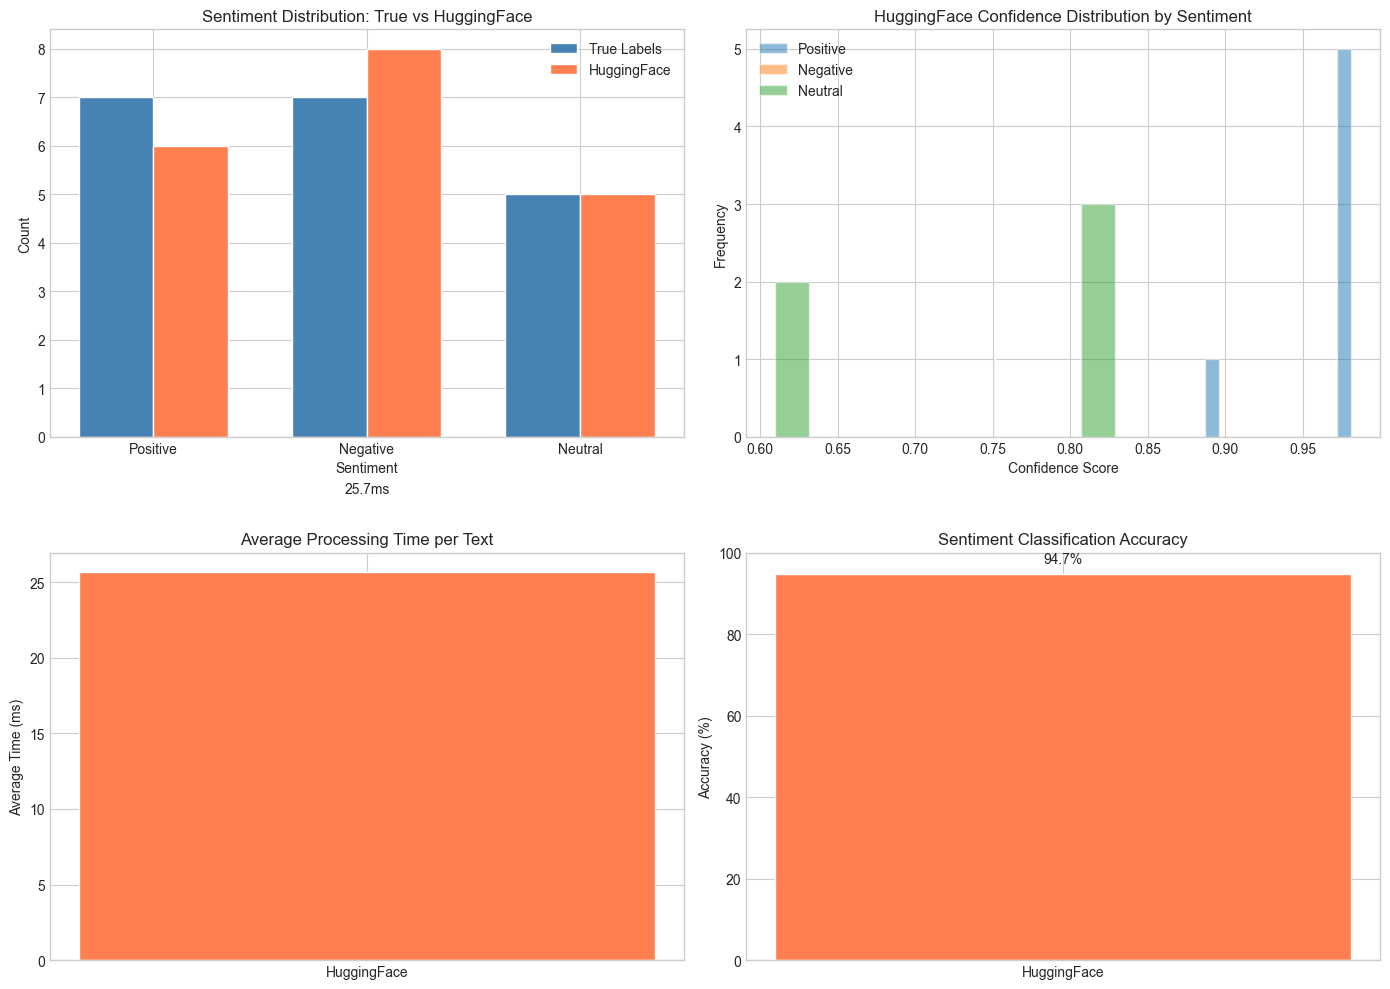


Visualization saved to 'comparison_results.png'


In [38]:
# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Sentiment Distribution Comparison
ax1 = axes[0, 0]
labels = ['Positive', 'Negative', 'Neutral']
true_counts = [sum(df['sentiment_label'] == l.lower()) for l in labels]
hf_counts = [sum(df['hf_sentiment'].str.lower() == l.lower()) for l in labels]

x = np.arange(len(labels))
width = 0.35

bars1 = ax1.bar(x - width/2, true_counts, width, label='True Labels', color='steelblue')
bars2 = ax1.bar(x + width/2, hf_counts, width, label='HuggingFace', color='coral')

ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.set_title('Sentiment Distribution: True vs HuggingFace')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

# 2. Confidence Score Distribution (HuggingFace)
ax2 = axes[0, 1]
for sentiment in ['positive', 'negative', 'neutral']:
    mask = df['hf_sentiment'].str.lower() == sentiment
    if mask.any():
        ax2.hist(df.loc[mask, 'hf_sentiment_score'], bins=10, alpha=0.5, label=sentiment.capitalize())

ax2.set_xlabel('Confidence Score')
ax2.set_ylabel('Frequency')
ax2.set_title('HuggingFace Confidence Distribution by Sentiment')
ax2.legend()

# 3. Processing Time Comparison
ax3 = axes[1, 0]
methods = ['HuggingFace']
times = [np.mean(hf_processing_times)]
colors = ['coral']

if USE_OLLAMA and ollama_processing_times:
    methods.append('Ollama')
    times.append(np.mean(ollama_processing_times))
    colors.append('steelblue')

bars = ax3.bar(methods, times, color=colors)
ax3.set_ylabel('Average Time (ms)')
ax3.set_title('Average Processing Time per Text')

for bar, t in zip(bars, times):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{t:.1f}ms', ha='center', va='bottom')

# 4. Accuracy Comparison
ax4 = axes[1, 1]
methods_acc = ['HuggingFace']
accuracies = [hf_accuracy['accuracy']]

if USE_OLLAMA and ollama_accuracy['total'] > 0:
    methods_acc.append('Ollama')
    accuracies.append(ollama_accuracy['accuracy'])

bars = ax4.bar(methods_acc, accuracies, color=['coral', 'steelblue'][:len(methods_acc)])
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Sentiment Classification Accuracy')
ax4.set_ylim(0, 100)

for bar, acc in zip(bars, accuracies):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'comparison_results.png'")

### 7.4 Detailed Analysis and Conclusions

In [39]:
# Detailed comparison table
print("=" * 80)
print("DETAILED COMPARISON: HuggingFace vs Ollama (Local LLM)")
print("=" * 80)

ollama_model_display = OLLAMA_MODEL if USE_OLLAMA else 'N/A'

comparison_data = {
    'Metric': ['Accuracy', 'Avg Processing Time', 'Cost per 1000 texts', 'Setup Complexity', 
               'Privacy', 'Offline Capability', 'Language Support', 'NER Quality'],
    'HuggingFace': [
        f"{hf_accuracy['accuracy']}%",
        f"{np.mean(hf_processing_times):.1f} ms",
        'Free (local)',
        'Medium (model download)',
        'Full (local processing)',
        'Yes',
        'Model-specific',
        'Good for Russian'
    ],
    'Ollama (Local)': [
        f"{ollama_accuracy['accuracy']}%" if USE_OLLAMA else 'N/A',
        f"{np.mean(ollama_processing_times):.1f} ms" if USE_OLLAMA and ollama_processing_times else 'N/A',
        'Free (local)',
        'Easy (install + pull model)',
        'Full (local processing)',
        'Yes',
        'Model-dependent (qwen2.5/mistral good for Russian)',
        'Good to Excellent'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "=" * 80)
print("CONCLUSIONS")
print("=" * 80)
print("""
1. ACCURACY:
   - HuggingFace models specifically trained for Russian (like rubert-base-cased-sentiment)
     can achieve good accuracy for sentiment analysis
   - Local LLMs via Ollama (especially qwen2.5, mistral) provide competitive accuracy
     with better context understanding

2. SPEED:
   - HuggingFace sentiment models are typically faster (single-task optimized)
   - Ollama LLMs are slower but more versatile (can do multiple tasks)
   - Both run locally with no network latency

3. COST:
   - Both are completely FREE - run entirely on local hardware
   - HuggingFace: Requires GPU for optimal performance
   - Ollama: Can run on CPU (slower) or GPU (faster)

4. PRIVACY:
   - Both solutions keep data 100% local
   - No data sent to external servers
   - Ideal for sensitive/confidential data

5. EASE OF USE:
   - HuggingFace: Requires model selection and potential fine-tuning
   - Ollama: Very easy - install, pull model, run

6. RECOMMENDATIONS:
   - For high-volume single-task processing: Use HuggingFace models
   - For flexible multi-task analysis: Use Ollama
   - For privacy-sensitive data: Both are excellent choices
   - For rapid prototyping: Ollama (easy setup, flexible)
   - Best Russian support in Ollama: qwen2.5, mistral
""")

DETAILED COMPARISON: HuggingFace vs Ollama (Local LLM)
             Metric             HuggingFace                                     Ollama (Local)
           Accuracy                  94.74%                                                N/A
Avg Processing Time                 25.7 ms                                                N/A
Cost per 1000 texts            Free (local)                                       Free (local)
   Setup Complexity Medium (model download)                        Easy (install + pull model)
            Privacy Full (local processing)                            Full (local processing)
 Offline Capability                     Yes                                                Yes
   Language Support          Model-specific Model-dependent (qwen2.5/mistral good for Russian)
        NER Quality        Good for Russian                                  Good to Excellent

CONCLUSIONS

1. ACCURACY:
   - HuggingFace models specifically trained for Russian (like 

## 8. Export Datasets for Fine-tuning

### 8.1 Create OpenAI Fine-tuning Format (JSONL)

In [40]:
def create_openai_finetuning_data(df: pd.DataFrame, output_file: str):
    """
    Create a JSONL file in OpenAI fine-tuning format.
    
    Format: {"messages": [{"role": "system", "content": "..."}, 
                          {"role": "user", "content": "..."},
                          {"role": "assistant", "content": "..."}]}
    """
    system_prompt = "You are a sentiment analysis assistant for Russian text. Classify the sentiment as positive, negative, or neutral."
    
    with open(output_file, 'w', encoding='utf-8') as f:
        for idx, row in df.iterrows():
            entry = {
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": f"Analyze the sentiment of this Russian review: {row['cleaned_review']}"},
                    {"role": "assistant", "content": json.dumps({"sentiment": row['sentiment_label']}, ensure_ascii=False)}
                ]
            }
            f.write(json.dumps(entry, ensure_ascii=False) + '\n')
    
    print(f"Created {output_file} with {len(df)} examples")


# Create fine-tuning dataset
create_openai_finetuning_data(df, 'fine_tuning_openai.jsonl')

# Display sample
print("\nSample entry:")
with open('fine_tuning_openai.jsonl', 'r', encoding='utf-8') as f:
    print(f.readline())

Created fine_tuning_openai.jsonl with 19 examples

Sample entry:
{"messages": [{"role": "system", "content": "You are a sentiment analysis assistant for Russian text. Classify the sentiment as positive, negative, or neutral."}, {"role": "user", "content": "Analyze the sentiment of this Russian review: Отличный товар! Заказывала в москве, доставили быстро рекомендую всем!"}, {"role": "assistant", "content": "{\"sentiment\": \"positive\"}"}]}



### 8.2 Create CSV Format

In [41]:
# Create CSV for fine-tuning
finetuning_df = df[['cleaned_review', 'sentiment_label', 'true_sentiment']].copy()
finetuning_df.columns = ['text', 'sentiment', 'sentiment_id']

finetuning_df.to_csv('fine_tuning_data.csv', index=False, encoding='utf-8')
print("Created fine_tuning_data.csv")
print(f"\nDataset shape: {finetuning_df.shape}")
print(f"\nSample data:")
finetuning_df.head()

Created fine_tuning_data.csv

Dataset shape: (19, 3)

Sample data:


,text,sentiment,sentiment_id
0,"Отличный товар! Заказывала в москве, доставили...",positive,1
1,Очень хороший магазин! Буду заказывать ещё,positive,1
2,Качество супер Иван Петров из СПб очень доволе...,positive,1
3,Мне оооочень понравилось! Спасибо магазину Озо...,positive,1
4,Превосходно! Анна Сидорова рекомендует этот то...,positive,1
